<a href="https://colab.research.google.com/github/thuvarahan97/Pump-it-Up---Driven-Data/blob/main/PumpItUp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [80]:
# pip install catboost

In [81]:
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.cluster import KMeans
from sklearn.model_selection import StratifiedKFold,train_test_split, KFold
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import Pool, CatBoostClassifier

In [82]:
def freq_enc(df,cols):
    for col in cols:
        df[col] = df[col].map(df[col].value_counts().to_dict())/len(df)
    return df

In [83]:
train_set = pd.read_csv('training_set_values.csv')
train_label = pd.read_csv('training_set_labels.csv')
test_set = pd.read_csv('test_set_values.csv')
submission = pd.read_csv('submission_format.csv')

In [84]:
test_copy = test_set.copy()
train_copy = train_set.copy()

In [85]:
train_set.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [86]:
test_set.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,50785,0.0,2013-02-04,Dmdd,1996,DMDD,35.290799,-4.059696,Dinamu Secondary School,0,Internal,Magoma,Manyara,21,3,Mbulu,Bashay,321,True,GeoData Consultants Ltd,Parastatal,NaN,True,2012,other,other,other,parastatal,parastatal,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other
1,51630,0.0,2013-02-04,Government Of Tanzania,1569,DWE,36.656709,-3.309214,Kimnyak,0,Pangani,Kimnyak,Arusha,2,2,Arusha Rural,Kimnyaki,300,True,GeoData Consultants Ltd,VWC,TPRI pipe line,True,2000,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe
2,17168,0.0,2013-02-01,NaN,1567,NaN,34.767863,-5.004344,Puma Secondary,0,Internal,Msatu,Singida,13,2,Singida Rural,Puma,500,True,GeoData Consultants Ltd,VWC,P,NaN,2010,other,other,other,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,other,other
3,45559,0.0,2013-01-22,Finn Water,267,FINN WATER,38.058046,-9.418672,Kwa Mzee Pange,0,Ruvuma / Southern Coast,Kipindimbi,Lindi,80,43,Liwale,Mkutano,250,NaN,GeoData Consultants Ltd,VWC,NaN,True,1987,other,other,other,vwc,user-group,unknown,unknown,soft,good,dry,dry,shallow well,shallow well,groundwater,other,other
4,49871,500.0,2013-03-27,Bruder,1260,BRUDER,35.006123,-10.950412,Kwa Mzee Turuka,0,Ruvuma / Southern Coast,Losonga,Ruvuma,10,3,Mbinga,Mbinga Urban,60,NaN,GeoData Consultants Ltd,Water Board,BRUDER,True,2000,gravity,gravity,gravity,water board,user-group,pay monthly,monthly,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe


In [87]:
train_set.shape

(59400, 40)

In [88]:
test_set.shape

(14850, 40)

In [89]:
# Assign index to each dataset
train_set = train_set.set_index('id')
test_set = test_set.set_index('id')

In [90]:
y = train_label['status_group'].values
train_label.head()

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional


In [91]:
# numeric_col = np.where(train_set.dtypes != object)[0]
# numeric_feat = [train_set.columns[x] for x in numeric_col]

In [92]:
# train_cluster_df = train_set[numeric_feat]
# test_cluster_df =  test_set[numeric_feat]

# train_cluster_df = train_cluster_df.fillna(-999)
# test_cluster_df = test_cluster_df.fillna(-999)

In [93]:
# kmeans = KMeans(4,random_state=42)
# kmeans.fit(train_cluster_df)
# train_set['clusters'] = kmeans.predict(train_cluster_df)
# test_set['clusters']  = kmeans.predict(test_cluster_df)

In [94]:
# Find the count of null values in train_data
train_set.isnull().sum()

amount_tsh                   0
date_recorded                0
funder                    3635
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     0
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3877
scheme_name              28166
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_group                0
quantity

In [95]:
# Find the count of null values in test_data
test_set.isnull().sum()

amount_tsh                  0
date_recorded               0
funder                    869
gps_height                  0
installer                 877
longitude                   0
latitude                    0
wpt_name                    0
num_private                 0
basin                       0
subvillage                 99
region                      0
region_code                 0
district_code               0
lga                         0
ward                        0
population                  0
public_meeting            821
recorded_by                 0
scheme_management         969
scheme_name              7092
permit                    737
construction_year           0
extraction_type             0
extraction_type_group       0
extraction_type_class       0
management                  0
management_group            0
payment                     0
payment_type                0
water_quality               0
quality_group               0
quantity                    0
quantity_g

In [96]:
train_set.describe()

,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


In [97]:
# Find the missing data
def findMissingData(data, title):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    missingdata=pd.concat([total, percent], axis=1, keys=['Total', 'Percentage'])
    missingdata= missingdata[missingdata["Percentage"] > 0]

    plt.subplots(figsize=(15,5))
    sns.barplot(missingdata.index, missingdata["Percentage"],color="red")
    plt.xlabel('Features', fontsize=14)
    plt.ylabel('Percentage', fontsize=14)
    plt.title('Feature vs. Percentage of missing data in ' + title, fontsize=14)
    
    return missingdata

Missing values in Train Data


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


,Total,Percentage
scheme_name,28166,47.417508
scheme_management,3877,6.526936
installer,3655,6.153199
funder,3635,6.119529
public_meeting,3334,5.612795
permit,3056,5.144781
subvillage,371,0.624579


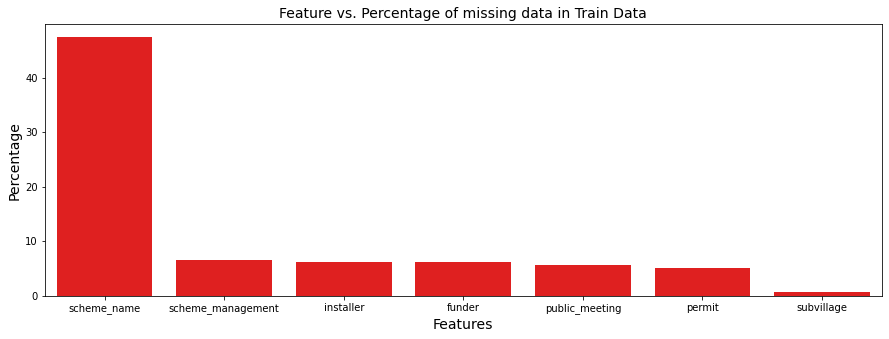

In [98]:
# Show missing values in train_data
print("Missing values in Train Data")
findMissingData(train_set, "Train Data")

Missing values in Test Data


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


,Total,Percentage
scheme_name,7092,47.757576
scheme_management,969,6.525253
installer,877,5.905724
funder,869,5.851852
public_meeting,821,5.528620
permit,737,4.962963
subvillage,99,0.666667


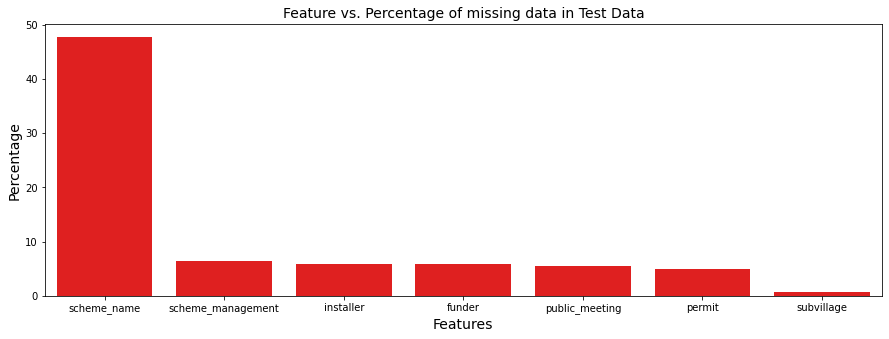

In [99]:
# Show missing values in test_data
print("Missing values in Test Data")
findMissingData(test_set, "Test Data")

In [100]:
# Drop "scheme_name" column in train_set and test_set
train_set.drop(['scheme_name'], axis=1, inplace = True)
test_set.drop(['scheme_name'], axis=1, inplace=True)

In [101]:
train_set['scheme_management'].fillna(train_set['scheme_management'].mode(), inplace = True)
test_set['scheme_management'].fillna(test_set['scheme_management'].mode(), inplace = True)

train_set['installer'].fillna(train_set['installer'].mode(), inplace = True)
test_set['installer'].fillna(test_set['installer'].mode(), inplace = True)

train_set['funder'].fillna(train_set['funder'].mode(), inplace = True)
test_set['funder'].fillna(test_set['funder'].mode(), inplace = True)

train_set['public_meeting'].fillna(train_set['public_meeting'].mode(), inplace = True)
test_set['public_meeting'].fillna(test_set['public_meeting'].mode(), inplace = True)

train_set['permit'].fillna(train_set['permit'].mode(), inplace = True)
test_set['permit'].fillna(test_set['permit'].mode(), inplace = True)

In [102]:
# Combine train_set and test_set
all_data = pd.concat([train_set, test_set], axis=0, sort=False)

In [103]:
all_data['scheme_management'].value_counts()

VWC                 45917
WUG                  6496
Water authority      3975
WUA                  3551
Water Board          3462
Parastatal           2124
Company              1341
Private operator     1326
Other                 996
SWC                   123
Trust                  92
None                    1
Name: scheme_management, dtype: int64

In [104]:
# # Replace "Sex" column values
# sex = {'female':0,'male':1}
# all_data['Sex'] = all_data['Sex'].map(sex)

In [105]:
# all_data['scheme_management'] = LabelEncoder().fit_transform(all_data['scheme_management'])

In [106]:
train_set.columns

Index(['amount_tsh', 'date_recorded', 'funder', 'gps_height', 'installer',
       'longitude', 'latitude', 'wpt_name', 'num_private', 'basin',
       'subvillage', 'region', 'region_code', 'district_code', 'lga', 'ward',
       'population', 'public_meeting', 'recorded_by', 'scheme_management',
       'permit', 'construction_year', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'management',
       'management_group', 'payment', 'payment_type', 'water_quality',
       'quality_group', 'quantity', 'quantity_group', 'source', 'source_type',
       'source_class', 'waterpoint_type', 'waterpoint_type_group'],
      dtype='object')

In [107]:
cols = ['amount_tsh', 'date_recorded', 'funder', 'gps_height', 'installer',
       'longitude', 'latitude', 'wpt_name', 'num_private', 'basin',
       'subvillage', 'region', 'region_code', 'district_code', 'lga', 'ward',
       'population', 'public_meeting', 'recorded_by', 'scheme_management',
       'permit', 'construction_year', 'extraction_type',
       'extraction_type_group', 'extraction_type_class', 'management',
       'management_group', 'payment', 'payment_type', 'water_quality',
       'quality_group', 'quantity', 'quantity_group', 'source', 'source_type',
       'source_class', 'waterpoint_type', 'waterpoint_type_group']

In [108]:
for col in cols:
    train_set[col] = train_set[col].apply(str)
    test_set[col] = test_set[col].apply(str)

In [109]:
# to_drop = ['behavioral_face_mask','behavioral_wash_hands','behavioral_touch_face','opinion_seas_vacc_effective',
#            'opinion_seas_risk','opinion_h1n1_vacc_effective','opinion_h1n1_risk','opinion_seas_vacc_effective',
#            'opinion_seas_sick_from_vacc','opinion_h1n1_vacc_effective','opinion_h1n1_sick_from_vacc','h1n1_concern',
#            'h1n1_knowledge','behavioral_large_gatherings','behavioral_outside_home','household_adults','household_children']

# train_set = train_set.drop(to_drop,axis=1)
# test_set = test_set.drop(to_drop,axis=1)

In [110]:
train_set['status_group'] = y

In [111]:
# target_mean = train_set.groupby(['clusters']).mean()[['status_group']]
# for i in list(target_mean.columns):
#   target_mean.rename({i:i+"_mean"},axis=1,inplace=True)
# train_set = train_set.merge(target_mean,how='left',on='clusters')
# test_set = test_set.merge(target_mean,how="left",on='clusters')

In [112]:
# freq_enc_index = np.where(train_set.dtypes == object)[0];
# freq_enc_cols = [train_set.columns[x] for x in freq_enc_index];freq_enc_cols[:5]

In [113]:
# train_set = train_set.fillna(-999)
# test_set = test_set.fillna(-999)

In [114]:
X = train_set.drop('status_group',axis=1)
y = train_set['status_group']
test = test_set.copy()

In [115]:
categorical = np.where(X.dtypes == object)[0];categorical

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37])

In [116]:
skf = StratifiedKFold(n_splits=10,random_state=42,shuffle=True)
cat = CatBoostClassifier(iterations=500,random_state=42,reg_lambda=30,eval_metric='AUC',custom_loss='Logloss')
pump_scores = []
pump_pred= np.zeros(len(test))
for fold, (train_index,test_index) in enumerate(skf.split(X,y)):
    print(f'====================================== FOLD {fold} ======================================================')
    X_train,X_test = X.iloc[train_index],X.iloc[test_index]
    y_train,y_test = y.iloc[train_index],y.iloc[test_index]
    cat.fit(X_train,y_train,early_stopping_rounds=500,eval_set=[(X_train,y_train),(X_test,y_test)],use_best_model=True,cat_features=categorical)
    pump_scores.append(roc_auc_score(y_test,cat.predict_proba(X_test)[:,1]))
    pump_pred +=cat.predict_proba(test_A)[:,1]

====================================== FOLD 0 ======================================================


CatBoostError: ignored

In [ ]:
pred = pump_pred/10

In [ ]:
np.mean(pump_scores)

In [ ]:
submission['status_group'] = pred

In [ ]:
submission.describe()

In [ ]:
submission.corr()

In [ ]:
submission.to_csv('submission.csv', index=False)

In [ ]:
# from google.colab import files
# files.download('submission.csv')